# Disruption type analysis

Scenario ID: 2
Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario  SlackMetric
0    deterministic_na_Scenario_001     0.668537
1    deterministic_na_Scenario_002     0.663849
2    deterministic_na_Scenario_003     0.709877
3    deterministic_na_Scenario_004     0.593474
4    deterministic_na_Scenario_005     0.702314
..                             ...          ...
695        mixed_high_Scenario_096     0.684293
696        mixed_high_Scenario_097     0.680254
697        mixed_high_Scenario_098     0.664708
698        mixed_high_Scenario_099     0.658414
699        mixed_high_Scenario_100     0.657952

[700 rows x 2 columns]


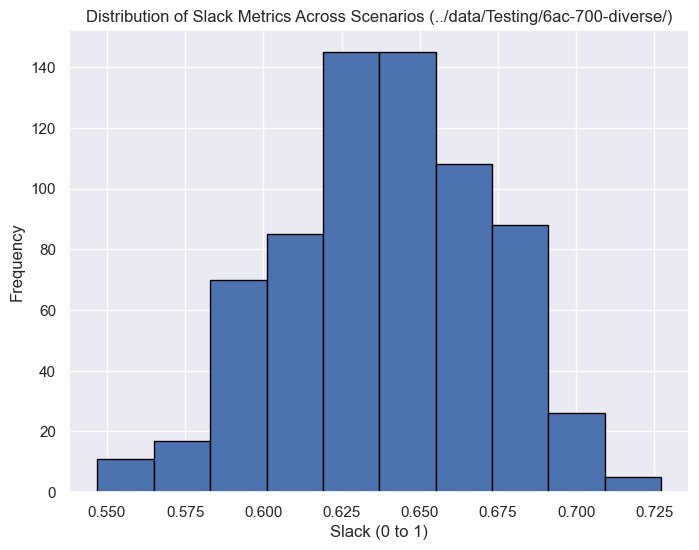

Slack metrics saved to ../logs/scenarios/scenario_slack_metrics_2.csv


In [7]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.

    Slack is defined as:
        Slack_ac = (Total flight time of aircraft ac) / H
    where H is the total scenario horizon (difference in minutes between earliest departure and latest arrival).

    The scenario slack is the average slack across all aircraft.
    """
    flights = scenario_data.get('flights', {})
    aircraft_ids = scenario_data.get('aircraft_ids', [])

    if len(flights) == 0:
        # No flights: scenario slack = 0
        return 0.0

    # Identify the overall scenario horizon
    dep_times = [time_to_minutes(f_data['DepTime']) for f_data in flights.values()]
    arr_times = [time_to_minutes(f_data['ArrTime']) for f_data in flights.values()]
    earliest_dep = min(dep_times)
    latest_arr = max(arr_times)
    horizon = max(latest_arr - earliest_dep, 1)  # Ensure no division by zero

    # Organize flights by aircraft
    aircraft_flights = {ac: [] for ac in aircraft_ids}
    for f_data in flights.values():
        dep = time_to_minutes(f_data['DepTime'])
        arr = time_to_minutes(f_data['ArrTime'])
        ac = f_data['Aircraft']
        aircraft_flights[ac].append((dep, arr))

    # Calculate slack per aircraft
    aircraft_slacks = []
    for ac, f_list in aircraft_flights.items():
        if len(f_list) == 0:
            # No flights for this aircraft: slack = 0
            ac_slack = 0.0
        else:
            total_flight_time = sum(arr - dep for dep, arr in f_list)
            ac_slack = total_flight_time / horizon
        aircraft_slacks.append(ac_slack)

    # Scenario slack is the average slack of all aircraft
    scenario_slack = sum(aircraft_slacks) / len(aircraft_slacks) if aircraft_slacks else 0.0
    return scenario_slack

# Path to the scenarios folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max(
    [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
    key=lambda x: int(x.split('_')[-1].replace('.json', ''))
)

latest_folder = "scenario_folder_scenario_2.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']

# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack for each scenario and store in a list of dicts
slack_results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack = calculate_slack_for_scenario(scenario_data)
    slack_results.append({"Scenario": scenario_name, "SlackMetric": scenario_slack})

# Convert results to DataFrame
slack_df = pd.DataFrame(slack_results)
print(slack_df)

# Plot the distribution of slack across scenarios
plt.figure(figsize=(8,6))
plt.hist(slack_df['SlackMetric'], bins=10, edgecolor='black')
plt.title(f"Distribution of Slack Metrics Across Scenarios ({data_folder})")
plt.xlabel("Slack (0 to 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Save the slack results to CSV
output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
slack_df.to_csv(output_file, index=False)
print(f"Slack metrics saved to {output_file}")


In [8]:
import os
import json
import time
import numpy as np
import pandas as pd
import torch
from datetime import datetime

from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.utils import load_scenario_data, NumpyEncoder, get_training_metadata
from scripts.logger import create_new_id, log_inference_metadata, find_corresponding_training_id, convert_to_serializable

def run_inference_dqn_single(model_path, scenario_folder, env_type, seed):
    """
    Runs inference on a single scenario and returns the total reward.
    """
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )

    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    while not done_flag and step_num < max_steps:
        action_mask = obs['action_mask']
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        # If no valid actions remain, break out
        if np.all(np.isinf(masked_q_values)):
            break

        action = np.argmax(masked_q_values)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        step_num += 1

    return total_reward

def run_inference_on_data_folder(model_paths, data_folder, seeds):
    """
    Runs inference on all scenarios found in 'data_folder', for each model in 'model_paths' and each seed in 'seeds'.

    Args:
        model_paths (list): List of model paths to run inference with.
        data_folder (str): Path to the folder containing scenario subfolders.
        env_type (str): Type of environment ("myopic", "proactive", "reactive").
        seeds (list): List of seeds for reproducibility.

    Returns:
        pd.DataFrame: A DataFrame containing scenario, model, seed, and total reward.
    """

    # Identify all scenario folders within data_folder
    scenario_folders = [
        os.path.join(data_folder, folder)
        for folder in os.listdir(data_folder)
        if os.path.isdir(os.path.join(data_folder, folder))
    ]

    results = []
    for scenario_folder in scenario_folders:
        scenario_name = os.path.basename(scenario_folder)
        for model_path in model_paths:
            for seed in seeds:
                # extract env_type from model_path
                env_type = model_path.split("/")[-2]
                total_reward = run_inference_dqn_single(model_path, scenario_folder, env_type, seed)
                results.append({
                    "Scenario": scenario_name,
                    "Model": os.path.basename(model_path),
                    "Seed": seed,
                    "TotalReward": total_reward
                })

    results_df = pd.DataFrame(results)
    return results_df


# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Define models and seeds
model_paths = [
    "../trained_models/dqn/6ac-700-diverse/23/myopic-training_8.zip",
    "../trained_models/dqn/6ac-700-diverse/23/proactive-training_9.zip",
    "../trained_models/dqn/6ac-700-diverse/23/reactive-training_10.zip"
]
seeds = [25]

results_df = run_inference_on_data_folder(model_paths, data_folder, seeds)
print(results_df)


Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario                     Model  Seed  \
0        mixed_medium_Scenario_015     myopic-training_8.zip    25   
1        mixed_medium_Scenario_015  proactive-training_9.zip    25   
2        mixed_medium_Scenario_015  reactive-training_10.zip    25   
3           mixed_low_Scenario_077     myopic-training_8.zip    25   
4           mixed_low_Scenario_077  proactive-training_9.zip    25   
...                            ...                       ...   ...   
2095   stochastic_low_Scenario_045  proactive-training_9.zip    25   
2096   stochastic_low_Scenario_045  reactive-training_10.zip    25   
2097  stochastic_high_Scenario_008     myopic-training_8.zip    25   
2098  stochastic_high_Scenario_008  proactive-training_9.zip    25   
2099  stochastic_high_Scenario_008  reactive-training_10.zip    25   

      TotalReward  
0         -3100.0  
1         -5900.0  
2         -5900.0  
3         -8074.0  
4        -127

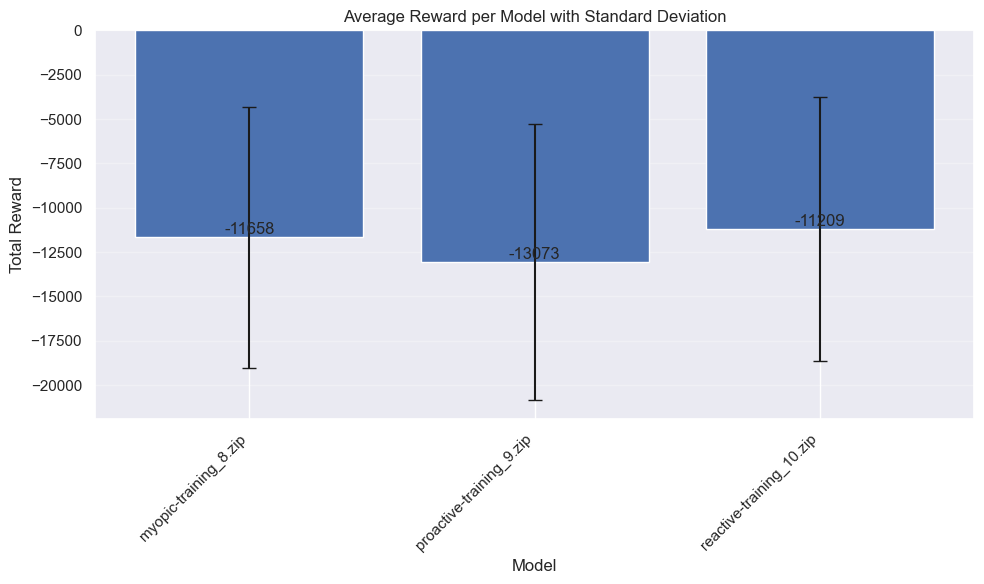

In [9]:

# Calculate mean and std of rewards per model
model_stats = results_df.groupby('Model').agg({
    'TotalReward': ['mean', 'std']
}).reset_index()
model_stats.columns = ['Model', 'Mean_Reward', 'Std_Reward']

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_stats['Model'], model_stats['Mean_Reward'], 
               yerr=model_stats['Std_Reward'], capsize=5)

# Customize plot
plt.title('Average Reward per Model with Standard Deviation')
plt.xlabel('Model')
plt.ylabel('Total Reward')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()



Pearson correlation between Slack and DeltaR: 0.0098, p-value: 7.9484e-01


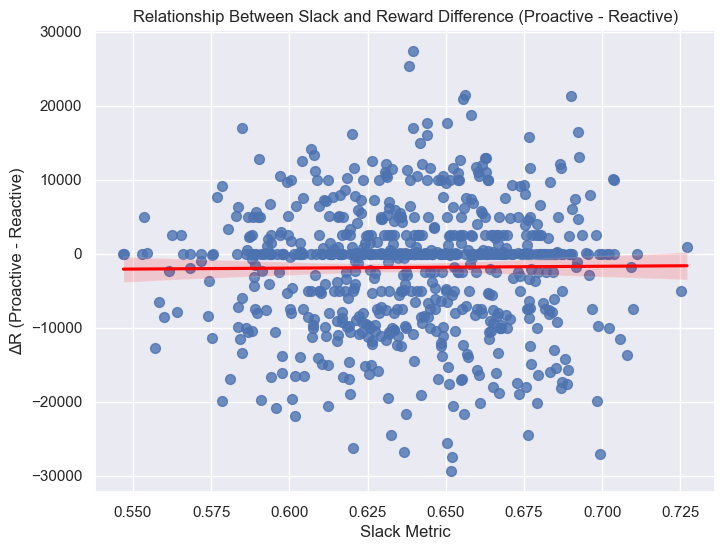

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

myopic_mask = results_df['Model'].str.contains('myopic', case=False)
proactive_mask = results_df['Model'].str.contains('proactive', case=False)
reactive_mask = results_df['Model'].str.contains('reactive', case=False)

# Pivot results_df to get one row per (Scenario, Seed) with columns for each model's reward
pivot_df = results_df.pivot_table(index=['Scenario','Seed'], columns='Model', values='TotalReward', aggfunc='mean').reset_index()

# Now we need to identify columns. The pivot will create columns named after each unique Model.
# We just find the one with 'myopic', 'proactive', 'reactive' in the name:
myopic_col = [c for c in pivot_df.columns if 'myopic' in c.lower()]
proactive_col = [c for c in pivot_df.columns if 'proactive' in c.lower()]
reactive_col = [c for c in pivot_df.columns if 'reactive' in c.lower()]

if not myopic_col or not proactive_col or not reactive_col:
    raise ValueError("Could not find all three models (myopic, proactive, reactive) in the results. Check model naming.")

myopic_col = myopic_col[0]
proactive_col = proactive_col[0]
reactive_col = reactive_col[0]

# Calculate Delta R = R_proactive - R_reactive
pivot_df['DeltaR'] = pivot_df[proactive_col] - pivot_df[reactive_col]

# Merge pivot_df with slack_df on Scenario
merged_df = pd.merge(pivot_df, slack_df, on='Scenario', how='left')

# Now merged_df contains "Scenario", "Seed", SlackMetric, and DeltaR
merged_df_avg = merged_df.groupby('Scenario', as_index=False).agg({'SlackMetric':'mean', 'DeltaR':'mean'})

# Calculate Pearson correlation
corr, p_value = pearsonr(merged_df_avg['SlackMetric'], merged_df_avg['DeltaR'])
print(f"Pearson correlation between Slack and DeltaR: {corr:.4f}, p-value: {p_value:.4e}")

# Plot the relationship
plt.figure(figsize=(8,6))
sns.regplot(x='SlackMetric', y='DeltaR', data=merged_df_avg, ci=95, scatter_kws={"s":50}, line_kws={"color":"red"})
plt.title("Relationship Between Slack and Reward Difference (Proactive - Reactive)")
plt.xlabel("Slack Metric")
plt.ylabel("ΔR (Proactive - Reactive)")
plt.grid(True)
plt.show()
